# EDA for modelling

## EDA Part 1- After initial filtering

This is a file that is used to check for different data in the cleaned dataset. This was built solely to do an EDA on the entire dataset, so that the transformations done during ETL can be made better, and a better quality of data can be obtained.

In [6]:
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Create a local spark session
spark = SparkSession.builder \
        .appName('nyc-taxi-sql') \
        .getOrCreate()

In [8]:
# load the file - Read parquet file
df = spark.read.load("./output")

In [9]:
df.printSchema()

root
 |-- taxi_colour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- week: string (nullable = true)
 |-- pickup_hour: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- duration_mins: double (nullable = true)
 |-- cat_duration: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- speed_mph: double (nullable = true)
 |-- trip_type: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [52]:
df.createOrReplaceTempView("v_df")

In [7]:
# Check whether total_amount > 1000 can be deleted or not- first get the count and then look at the data
spark.sql('''select count(*)
          from v_df where total_amount > 1000''').show()

+--------+
|count(1)|
+--------+
|       6|
+--------+



In [7]:
spark.sql('''select round(duration_mins, 4) as dur, passenger_count, trip_distance, ratecodeID,
          payment_type, fare_amount, extra, tip_amount, total_amount
          from v_df where total_amount > 1000 order by total_amount asc''').show(20)

+--------+---------------+-------------+----------+------------+-----------+------+----------+------------+
|     dur|passenger_count|trip_distance|ratecodeID|payment_type|fare_amount| extra|tip_amount|total_amount|
+--------+---------------+-------------+----------+------------+-----------+------+----------+------------+
|  0.9167|              1|          5.7|         5|           3|     999.98|   0.0|       0.0|     1000.28|
|  0.2333|              1|          7.7|         5|           1|        0.0|   0.0|    999.99|     1000.29|
|    0.45|              1|          7.7|         5|           1|        0.0|   0.0|    999.99|     1000.29|
|  0.5667|              1|          1.9|         5|           1|        0.0|   0.0|    999.99|     1000.29|
|  0.4833|              1|          1.2|         5|           1|      900.0|   0.0|     100.0|      1000.3|
|637.2333|              3|        360.5|         1|           3|      989.0|   0.5|       0.0|      1000.8|
| 42.5833|              1|  

In [8]:
# Check whether duration_mins < 1 can be deleted or not- first get the count and then look at the data
spark.sql('''select duration_mins, fare_amount
          from v_df where duration_mins < 1 and fare_amount > 100 order by fare_amount asc''').show(20)

+--------------------+-----------+
|       duration_mins|fare_amount|
+--------------------+-----------+
|  0.7166666666666667|     100.01|
|  0.9833333333333333|     100.02|
|0.016666666666666666|     100.05|
|  0.5166666666666667|     100.05|
|                 0.7|     100.12|
|  0.7333333333333333|      100.2|
|  0.5166666666666667|      100.3|
|  0.5666666666666667|      100.3|
|  0.6333333333333333|      100.5|
|                 0.5|     100.54|
|  0.9833333333333333|     100.66|
|  0.7333333333333333|      100.8|
|                0.25|      101.0|
| 0.03333333333333333|      101.0|
|  0.2833333333333333|      101.0|
|  0.7333333333333333|      101.0|
|  0.3333333333333333|      101.0|
|  0.2833333333333333|      101.0|
|  0.6333333333333333|      101.0|
|                0.45|      101.0|
+--------------------+-----------+
only showing top 20 rows



In [9]:
# Check whether duration_mins < 1 can be deleted or not- first get the count and then look at the data
spark.sql('''select count(1)
          from v_df where duration_mins < 1 and fare_amount > 100''').show(100)

+--------+
|count(1)|
+--------+
|    5745|
+--------+



In [12]:
spark.sql('''
select taxi_colour
    ,ROUND(AVG(duration_mins), 6) as avg_duration_mins
    ,ROUND(percentile_approx(duration_mins, 0.5), 6) as median_duration_mins
    ,ROUND(min(duration_mins), 6) as min_duration_mins
    ,ROUND(max(duration_mins), 6) as max_duration_mins
    FROM v_df
    group by taxi_colour
''').show()

+-----------+-----------------+--------------------+-----------------+------------------+
|taxi_colour|avg_duration_mins|median_duration_mins|min_duration_mins| max_duration_mins|
+-----------+-----------------+--------------------+-----------------+------------------+
|      green|        21.735881|           12.583333|         0.016667|       3885.633333|
|     yellow|        22.269378|           13.683333|         0.016667|1.25373160833333E8|
+-----------+-----------------+--------------------+-----------------+------------------+



In [13]:
spark.sql('''
select passenger_count, trip_distance, ratecodeID,
          payment_type, fare_amount, extra, tip_amount, total_amount, duration_mins from v_df order by duration_mins desc
''').show()

+---------------+-------------+----------+------------+-----------+-----+----------+------------+--------------------+
|passenger_count|trip_distance|ratecodeID|payment_type|fare_amount|extra|tip_amount|total_amount|       duration_mins|
+---------------+-------------+----------+------------+-----------+-----+----------+------------+--------------------+
|              1|          1.8|         1|           2|        9.0|  1.0|       0.0|        10.8|1.2537316083333333E8|
|              1|         11.1|         1|           2|       44.0|  1.0|       0.0|        45.8|1.2537309018333334E8|
|              1|          1.5|         1|           1|        8.0|  1.0|      1.96|       11.76|       1.253730782E8|
|              1|          1.0|         1|           1|        6.0|  1.0|      1.95|        9.75|       1.253730648E8|
|              1|          3.6|         1|           2|       16.0|  1.0|       0.0|        17.8|1.2537303843333334E8|
|              1|          1.6|         1|      

In [53]:
# Number of trips by passengers
spark.sql('''
select passenger_count, count(1) as trips from v_df group by passenger_count order by passenger_count asc
''').show()

+---------------+---------+
|passenger_count|    trips|
+---------------+---------+
|              1|223511307|
|              2| 42232999|
|              3| 12282114|
|              4|  5819316|
|              5| 15915592|
|              6|  9848920|
|              7|      604|
|              8|      586|
|              9|      307|
+---------------+---------+



In [11]:
# checking count of trips by duration and RatecodeID
spark.sql('''
    select cat_duration, RatecodeID, total_amount, tip_amount
    from v_df where RatecodeID=5 and duration_mins > 30 order by total_amount desc
''').show(60)

+-------------+----------+------------+----------+
| cat_duration|RatecodeID|total_amount|tip_amount|
+-------------+----------+------------+----------+
|Above 30 mins|         5|       200.0|     10.16|
|Above 30 mins|         5|       200.0|      27.2|
|Above 30 mins|         5|       200.0|      19.2|
|Above 30 mins|         5|       200.0|      14.7|
|Above 30 mins|         5|       200.0|       0.0|
|Above 30 mins|         5|       200.0|      38.2|
|Above 30 mins|         5|       200.0|      12.8|
|Above 30 mins|         5|       200.0|     26.87|
|Above 30 mins|         5|       200.0|       0.0|
|Above 30 mins|         5|       200.0|       4.7|
|Above 30 mins|         5|       200.0|      18.7|
|Above 30 mins|         5|       200.0|     24.41|
|Above 30 mins|         5|       200.0|     11.91|
|Above 30 mins|         5|       200.0|     26.76|
|Above 30 mins|         5|       200.0|      41.7|
|Above 30 mins|         5|       200.0|     23.87|
|Above 30 mins|         5|     

In [12]:
# checking count of trips by duration and RatecodeID
spark.sql('''
    select cat_duration, RatecodeID, count(1) as number_of_trips, ROUND(AVG(trip_distance * 1.609 /total_amount), 6) as avg_km_dollar
    from v_df
    group by cat_duration, RatecodeID order by cat_duration, RatecodeID asc
''').show(60)

+-------------+----------+---------------+-------------+
| cat_duration|RatecodeID|number_of_trips|avg_km_dollar|
+-------------+----------+---------------+-------------+
|   10-20 mins|         1|      108120969|     0.272922|
|   10-20 mins|         2|          56199|      0.19143|
|   10-20 mins|         3|           8073|     0.220959|
|   10-20 mins|         4|          22489|     0.381363|
|   10-20 mins|         5|         277147|     1.170162|
|   10-20 mins|         6|            105|     1.248373|
|   20-30 mins|         1|       38146871|     0.311747|
|   20-30 mins|         2|         736393|     0.430581|
|   20-30 mins|         3|         123123|      0.30607|
|   20-30 mins|         4|          34321|     0.390244|
|   20-30 mins|         5|         166427|     1.946717|
|   20-30 mins|         6|             46|     1.322628|
|    5-10 mins|         1|       92024757|     0.225567|
|    5-10 mins|         2|          22551|     0.062545|
|    5-10 mins|         3|     

## EDA Part II- Checking the distributions with a sample

In [17]:
# Get a sample of around 50k rows
number_of_samples= 50000
fraction_of_samples = number_of_samples/(df.count())

sample_df = df.sample(fraction_of_samples)

print(sample_df.count())

49802


(array([1.458e+03, 6.228e+03, 7.823e+03, 7.189e+03, 6.044e+03, 4.689e+03,
        3.679e+03, 2.912e+03, 2.097e+03, 1.587e+03, 1.338e+03, 9.550e+02,
        7.830e+02, 5.810e+02, 4.670e+02, 3.620e+02, 2.840e+02, 2.300e+02,
        2.260e+02, 1.710e+02, 1.290e+02, 9.800e+01, 8.900e+01, 6.400e+01,
        5.600e+01, 5.800e+01, 4.200e+01, 2.700e+01, 2.700e+01, 1.900e+01,
        1.600e+01, 1.400e+01, 7.000e+00, 9.000e+00, 8.000e+00, 8.000e+00,
        8.000e+00, 2.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.66666667e-02, 2.56266667e+00, 5.10866667e+00, 7.65466667e+00,
        1.02006667e+01, 1.27466667e+01, 1.52926667e+01, 1.78386667e+01,
        2.03846667e+01, 2.29306667e+01, 2.54766667e+01, 2.80226667e+01,
        3.05686667e+01, 3.31146667e+01, 3.56606667e+01, 3.82066667e+01,
        4.07526667e+01, 4.32986667e+01, 4.58446667e+01, 4.83906667e+01,
        5.093666

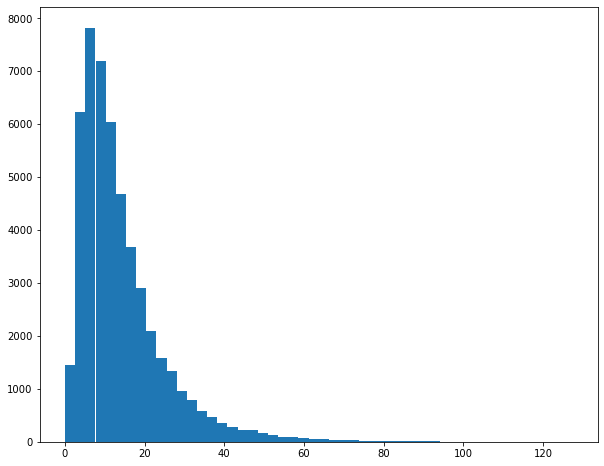

In [19]:
# plot distribution of duration
plt.figure(figsize=(10,8))
bins= 50

hist_data= sample_df.select('duration_mins').rdd.flatMap(lambda x: x).histogram(bins)

bins= hist_data[0]

count= hist_data[1]

# This is a bit awkward but I believe this is the correct way to do it 
plt.hist(bins[:-1], bins=bins, weights=count)

(array([2.0185e+04, 1.4983e+04, 5.6690e+03, 2.8060e+03, 1.5300e+03,
        1.0130e+03, 9.3400e+02, 6.8200e+02, 4.0600e+02, 2.1300e+02,
        1.8300e+02, 2.8200e+02, 4.4100e+02, 2.1800e+02, 1.1600e+02,
        7.7000e+01, 2.2000e+01, 9.0000e+00, 6.0000e+00, 8.0000e+00,
        9.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([9.99999978e-03, 1.43933331e+00, 2.86866663e+00, 4.29799994e+00,
        5.72733325e+00, 7.15666656e+00, 8.58599988e+00, 1.00153332e+01,
        1.14446665e+01, 1.28739998e+01, 1.43033331e+01, 1.57326664e+01,
        1.71619998e+01, 1.85913331e+01, 2.00206664e+01, 2.14499997e+01,
        2.28793330e+01, 2.43086663e+01, 2.57379996e+01, 2.71673329e+01,
        2.85966663e+01, 3.00259996e+01, 3.14553329e+01, 3.28846662e+01,
        3.43139995e+01, 3.57433328e+01, 3.71726661e+01, 3.86019995e+01,
        4.00313328e+01, 4.14606661e+01, 4.28899994e+01]),
 <a list of 30 Patch objects

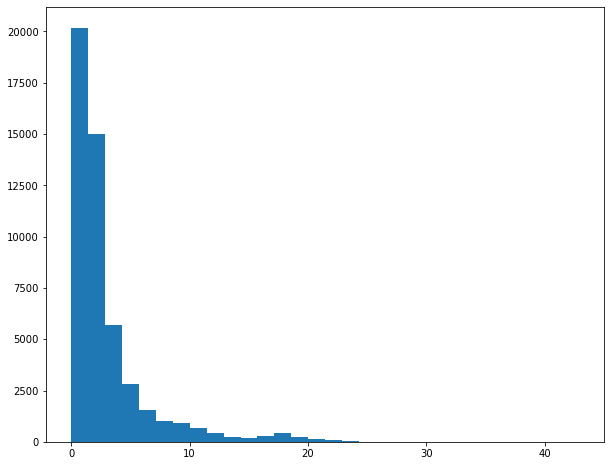

In [22]:
# plot distribution of distance
plt.figure(figsize=(10,8))
bins= 30

hist_data= sample_df.select('trip_distance').rdd.flatMap(lambda x: x).histogram(bins)

bins= hist_data[0]

count= hist_data[1]

# Plot a histogram now
plt.hist(bins[:-1], bins=bins, weights=count)

Looking at the above plot, we can say that most of the distance is between 0 and 30 miles.

(array([3.0120e+03, 2.2406e+04, 1.2069e+04, 5.1010e+03, 2.4280e+03,
        1.2790e+03, 8.9800e+02, 6.9000e+02, 4.7500e+02, 5.4400e+02,
        2.7600e+02, 3.5900e+02, 1.3800e+02, 3.6000e+01, 2.3000e+01,
        7.0000e+00, 2.1000e+01, 1.1000e+01, 7.0000e+00, 7.0000e+00,
        5.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.        ,   6.02666677,  12.05333354,  18.08000031,
         24.10666707,  30.13333384,  36.16000061,  42.18666738,
         48.21333415,  54.24000092,  60.26666768,  66.29333445,
         72.32000122,  78.34666799,  84.37333476,  90.40000153,
         96.42666829, 102.45333506, 108.48000183, 114.5066686 ,
        120.53333537, 126.56000214, 132.5866689 , 138.61333567,
        144.64000244, 150.66666921, 156.69333598, 162.72000275,
        168.74666951, 174.77333628, 180.80000305]),
 <a list of 30 Patch objects>)

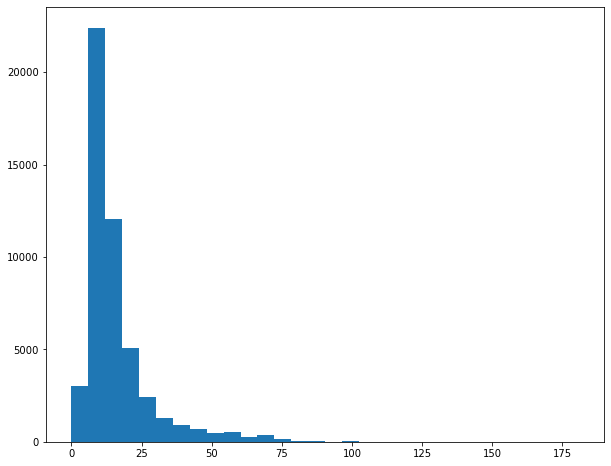

In [24]:
# plot distribution of total_amount
plt.figure(figsize=(10,8))
bins= 30

hist_data= sample_df.select('total_amount').rdd.flatMap(lambda x: x).histogram(bins)

bins= hist_data[0]

count= hist_data[1]

# Plot a histogram now
plt.hist(bins[:-1], bins=bins, weights=count)

## Box plot 

## Decisions to be made after :

1. Find direct distance using Longitudes and Latitude, 
2. Remove extreme values of trip-distance
3. Remove extreme values of trip-time

### Check correlations in the sample

In [25]:
# correlation between the variables
df_features = sample_df.select("total_amount", "week","duration_mins","passenger_count","trip_distance", "speed_mph") 

# create RDD table for correlation calculation
rdd_table = df_features.rdd.map(lambda row: row[0:])

# get the correlation matrix
corr_mat=Statistics.corr(rdd_table, method="pearson")

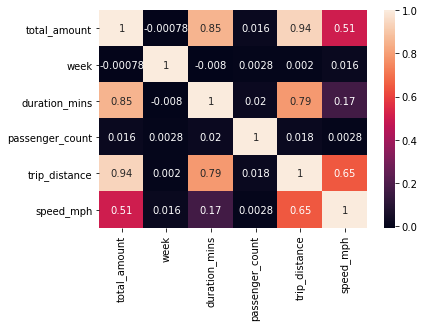

In [27]:
import seaborn as sn

axis_labels = ["total_amount", "week","duration_mins","passenger_count","trip_distance", "speed_mph"] # labels for the axes

# create seabvorn heatmap with required labels
sn.heatmap(corr_mat, xticklabels=axis_labels, yticklabels=axis_labels, annot=True)

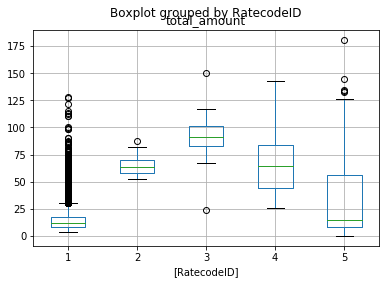

In [46]:
# Check the distribution of total amount with RatecodeID
sample_df.createOrReplaceTempView("v_sample")

pandas_df = spark.sql("select v_sample.RatecodeID, v_sample.total_amount from v_sample").toPandas()

pandas_df.boxplot(by='RatecodeID')

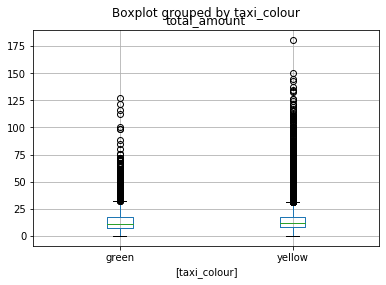

In [47]:
# Check the distribution of total amount with taxi colour

pandas_df = spark.sql("select v_sample.taxi_colour, v_sample.total_amount from v_sample").toPandas()

pandas_df.boxplot(by='taxi_colour')

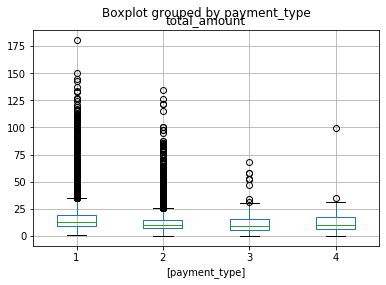

In [48]:
# Check the distribution of total amount with payment type

pandas_df = spark.sql("select v_sample.payment_type, v_sample.total_amount from v_sample").toPandas()

pandas_df.boxplot(by='payment_type')

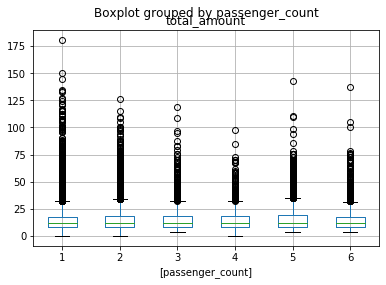

In [49]:
# Check the distribution of total amount with passenger count

pandas_df = spark.sql("select v_sample.passenger_count, v_sample.total_amount from v_sample").toPandas()

pandas_df.boxplot(by='passenger_count')

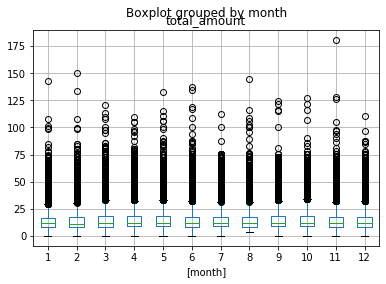

In [50]:
# Check the distribution of total amount with month

pandas_df = spark.sql("select v_sample.month, v_sample.total_amount from v_sample").toPandas()

pandas_df.boxplot(by='month')

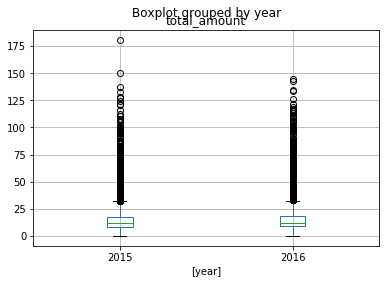

In [51]:
# Check the distribution of total amount with year

pandas_df = spark.sql("select v_sample.year, v_sample.total_amount from v_sample").toPandas()

pandas_df.boxplot(by='year')